In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE

C:\Users\GEETHU\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# 1. Load Dataset
df = pd.read_csv('creditcard.csv')
print("Data shape:", df.shape)
print(df.head(100))

Data shape: (284807, 31)
    Time        V1        V2        V3        V4        V5        V6  \
0    0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388   
1    0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361   
2    1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499   
3    1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203   
4    2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921   
..   ...       ...       ...       ...       ...       ...       ...   
95  64.0 -0.658305  0.406791  2.037461 -0.291298  0.147910 -0.350857   
96  64.0  0.959602  0.370711  0.888613  2.343244  0.352491  1.365515   
97  67.0 -0.653445  0.160225  1.592256  1.296832  0.997175 -0.343000   
98  67.0 -1.494668  0.837241  2.628211  3.145414 -0.609098  0.258495   
99  68.0  1.232996  0.189454  0.491040  0.633673 -0.511574 -0.990609   

          V7        V8        V9  ...       V21       V22       V23       V24  \
0   0.239599  0.098698  0.363

In [3]:
# 2. EDA
print(df['Class'].value_counts())  # 0 = normal, 1 = fraud

Class
0    284315
1       492
Name: count, dtype: int64


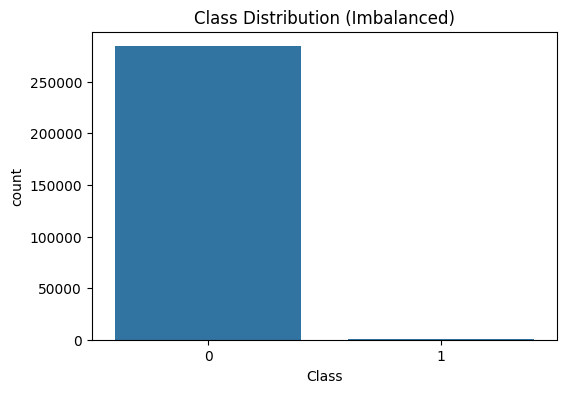

In [4]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Class')
plt.title("Class Distribution (Imbalanced)")
plt.show()


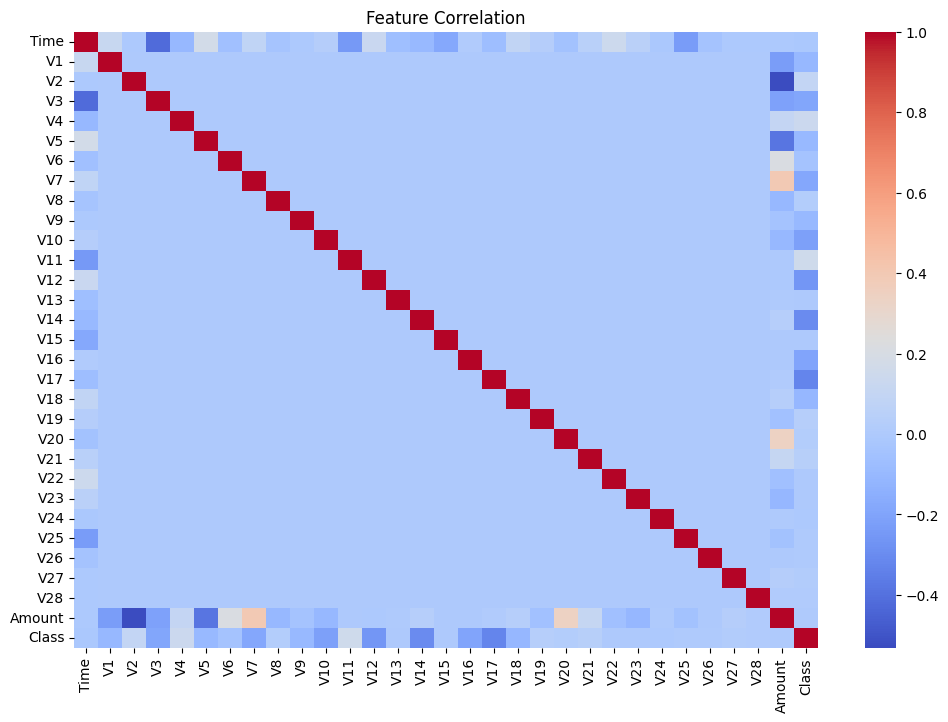

In [5]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap="coolwarm", cbar=True)
plt.title("Feature Correlation")
plt.show()

In [6]:
# 3. Preprocessing
X = df.drop(['Class', 'Time'], axis=1)  # Drop 'Time' as it's not useful
y = df['Class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [7]:
# 4. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)


In [8]:

# 5. Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_train_res))

Before SMOTE: [227451    394]
After SMOTE: [227451 227451]



 Training: Logistic Regression
Confusion Matrix:
 [[55343  1521]
 [    8    90]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9999    0.9733    0.9864     56864
           1     0.0559    0.9184    0.1053        98

    accuracy                         0.9732     56962
   macro avg     0.5279    0.9458    0.5458     56962
weighted avg     0.9982    0.9732    0.9849     56962

AUC Score: 0.9706

 Training: Random Forest
Confusion Matrix:
 [[56852    12]
 [   17    81]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9997    0.9998    0.9997     56864
           1     0.8710    0.8265    0.8482        98

    accuracy                         0.9995     56962
   macro avg     0.9353    0.9132    0.9240     56962
weighted avg     0.9995    0.9995    0.9995     56962

AUC Score: 0.9839

 Training: XGBoost


C:\Users\GEETHU\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:15:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix:
 [[56828    36]
 [   14    84]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9998    0.9994    0.9996     56864
           1     0.7000    0.8571    0.7706        98

    accuracy                         0.9991     56962
   macro avg     0.8499    0.9283    0.8851     56962
weighted avg     0.9992    0.9991    0.9992     56962

AUC Score: 0.9751


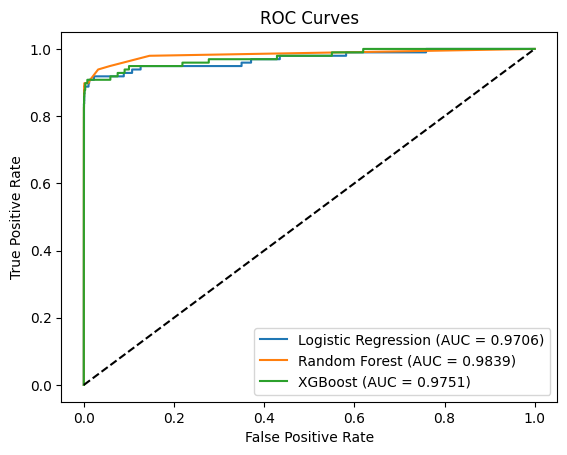

In [9]:
# 6. Model Training
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

for name, model in models.items():
    print(f"\n Training: {name}")
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)

    # Classification Report
    print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

    # AUC Score
    auc = roc_auc_score(y_test, y_proba)
    print(f"AUC Score: {auc:.4f}")

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')
    
plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()